In [1]:
from multiprocessing.dummy import Pool
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os
import pandas as pd 
import pickle
import requests
import re
import seaborn as sns
from scipy.stats import gmean
import torch 
from transformers import AutoTokenizer, AutoModelForMaskedLM
import warnings

warnings.filterwarnings("ignore")
CURRENT_DIR = os.getcwd()
os.chdir(CURRENT_DIR)

In [3]:
import pkg_resources

packages = ["numpy", "scipy", "matplotlib", "pandas", "requests", "seaborn", "scipy", "scikit-learn", "torch", "transformers"]

with open("packages.txt", "w") as f:
    for package in packages:
        version = pkg_resources.get_distribution(package).version
        f.write(f"{package}: {version}\n")

## Script to download the SABIO-RK dataset and generate ESM-2 enzyme and ChemBERTa-2 substrate representations of wild type and mutant enzymes. The BRENDA preprocessed data is then added to create the final dataset

Download reaction information

In [ ]:
ENTRYID_QUERY_URL = 'https://sabiork.h-its.org/sabioRestWebServices/searchKineticLaws/entryIDs'
PARAM_QUERY_URL = 'https://sabiork.h-its.org/entry/exportToExcelCustomizable'

query_dict = {'EntryID': '*'}
query_string = ' OR '.join(['%s:%s' % (k, v) for k, v in query_dict.items()])
query = {'format': 'txt', 'q': query_string}

response = requests.get(ENTRYID_QUERY_URL, params=query)
response.raise_for_status()

entryIDs = [int(x) for x in response.text.strip().split('\n')]
print(f'{len(entryIDs)} matching entries selected.')

data_field = [('entryIDs[]', eid) for eid in entryIDs]  
query = {
    'format': 'tsv',
    'fields[]': [
        'EntryID', 'Organism', 'UniprotID', 'ECNumber', "Pathway", 'Parameter',
        'EnzymeType', "Enzymename", "KeggReactionID", "PubMedID", "Substrate",
        "Product", "PubChemID", "InChI", "Smiles"]}

print("Downloading...")
response = requests.post(PARAM_QUERY_URL, params=query, data=data_field)
response.raise_for_status()
print("Download finished!", len(response.text.split("\n")), "lines")

results = [x.split("\t") for x in response.text.strip().split("\n")]
headers = results.pop(0)
df = pd.DataFrame(results, columns=headers)
df

In [25]:
dx = pd.read_pickle(join("files","sabio_rk_reactions_dataframe.pkl"))
dx = dx[(dx["parameter.type"] == "Km") & (dx["parameter.unit"] == "M")]

dx = dx[dx["parameter.startValue"].astype(str) != ""]
dx = dx[dx["parameter.startValue"].astype(float) != 0]

dx = dx[dx["UniprotID"].notnull() & (dx["UniprotID"] != "")] 
dx["Km"] = dx["parameter.startValue"].astype(float)  

dx = pd.DataFrame({
    "Organism": dx["Organism"],
    "ECNumber": dx["ECNumber"],
    "Km": dx["parameter.startValue"].astype(float),
    "UniprotID": dx["UniprotID"],
    "Substrate": dx["parameter.associatedSpecies"],
    "UniprotID": dx["UniprotID"],
    "Type": dx["EnzymeType"]})

dx.reset_index(inplace= True)
dx

,index,Organism,ECNumber,Km,UniprotID,Substrate,Type
0,4,Pseudomonas putida,1.1.99.31,0.002300,P20932,(S)-Mandelate,mutant MDH G81S
1,8,Pseudomonas putida,1.1.99.31,0.000170,P20932,(S)-Mandelate,mutant MDH G81V
2,10,Pseudomonas putida,1.1.99.31,0.002000,P20932,(S)-Mandelate,mutant MDH G81D
3,15,Pseudomonas putida,1.1.99.31,0.000090,P20932,(S)-Mandelate,mutant chimeric MDH-GOX2
4,18,Pseudomonas putida,1.1.99.31,0.000040,P20932,(S)-Mandelate,mutant G81A of chimeric MDH-GOX2
...,...,...,...,...,...,...,...
6844,44638,Rattus norvegicus,1.1.1.44,0.000019,Q7TP11,6-Phospho-D-gluconate,wildtype
6845,44643,Rattus norvegicus,1.1.1.44,0.000056,Q7TP11,NADP+,wildtype
6846,44646,Rattus norvegicus,1.1.1.44,0.000258,Q7TP11,NADP+,wildtype
6847,44655,Rattus norvegicus,1.1.1.44,0.000356,Q7TP11,NADP+,wildtype


Convert units

In [26]:
dx["Km_mM"] = dx["Km"] * 1e3
dx["km"] = dx["Km_mM"]
dx.drop(columns=["index","Km_mM", "Km"], inplace=True)
dx

,Organism,ECNumber,UniprotID,Substrate,Type,km
0,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81S,2.300
1,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81V,0.170
2,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81D,2.000
3,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant chimeric MDH-GOX2,0.090
4,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant G81A of chimeric MDH-GOX2,0.040
...,...,...,...,...,...,...
6844,Rattus norvegicus,1.1.1.44,Q7TP11,6-Phospho-D-gluconate,wildtype,0.019
6845,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.056
6846,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.258
6847,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.356


Set the substrates

In [27]:
unique_substrates_df = dx[["Substrate"]].drop_duplicates().reset_index(drop=True)
unique_substrates_df

,Substrate
0,(S)-Mandelate
1,O2
2,Dihydrofolate
3,Chitobiose
4,Mg2+
...,...
998,"1-Phosphatidyl-D-myo-inositol 4,5-bisphosphate"
999,L-Xylose
1000,D-Lyxose
1001,Peptide-thiobenzyl ester


Retrive smiles from PubChem

In [ ]:
name_to_smiles = {}

def get_smiles(name):
    try:
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/CanonicalSMILES/TXT"
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            smiles = response.content.decode().strip()
        else:
            smiles = None
    except:
        smiles = None
    name_to_smiles[name] = smiles


unique_names = unique_substrates_df["Substrate"].dropna().unique().tolist()

thread_pool = Pool(4)
thread_pool.map(get_smiles, unique_names)
thread_pool.close()
thread_pool.join()

unique_substrates_df["smiles"] = unique_substrates_df["Substrate"].map(name_to_smiles)
unique_substrates_df = unique_substrates_df.dropna(subset="smiles")
unique_substrates_df

In [ ]:
unique_substrates_df.to_pickle(join("files","unique_substrates_smiles_sabio.pkl"))

Add smiles

In [ ]:
unique_substrates_df = pd.read_pickle(join("files","unique_substrates_smiles_sabio.pkl"))
dx = pd.merge(dx, unique_substrates_df, on="Substrate", how="left")
dx = dx.dropna(subset=["smiles"]).reset_index(drop=True)
dx

,Organism,ECNumber,UniprotID,Substrate,Type,km,smiles
0,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81S,2.300,C1=CC=C(C=C1)C(C(=O)[O-])O
1,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81V,0.170,C1=CC=C(C=C1)C(C(=O)[O-])O
2,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81D,2.000,C1=CC=C(C=C1)C(C(=O)[O-])O
3,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant chimeric MDH-GOX2,0.090,C1=CC=C(C=C1)C(C(=O)[O-])O
4,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant G81A of chimeric MDH-GOX2,0.040,C1=CC=C(C=C1)C(C(=O)[O-])O
...,...,...,...,...,...,...,...
6075,Rattus norvegicus,1.1.1.44,Q7TP11,6-Phospho-D-gluconate,wildtype,0.019,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O
6076,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.056,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...
6077,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.258,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...
6078,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.356,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...


Remove duplicates and incomplete entries

In [29]:
dx = dx.drop_duplicates(["ECNumber", "km", "Substrate", "UniprotID"]) 
dx = dx.reset_index(drop=True)

dx = dx.loc[~pd.isnull(dx["UniprotID"])]
dx = dx.loc[~pd.isnull(dx["Substrate"])]
dx = dx.loc[~pd.isnull(dx["km"])]
dx

,Organism,ECNumber,UniprotID,Substrate,Type,km,smiles
0,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81S,2.300,C1=CC=C(C=C1)C(C(=O)[O-])O
1,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81V,0.170,C1=CC=C(C=C1)C(C(=O)[O-])O
2,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81D,2.000,C1=CC=C(C=C1)C(C(=O)[O-])O
3,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant chimeric MDH-GOX2,0.090,C1=CC=C(C=C1)C(C(=O)[O-])O
4,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant G81A of chimeric MDH-GOX2,0.040,C1=CC=C(C=C1)C(C(=O)[O-])O
...,...,...,...,...,...,...,...
5574,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.056,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...
5575,Rattus norvegicus,1.1.1.44,Q7TP11,6-Phospho-D-gluconate,wildtype,0.157,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O
5576,Rattus norvegicus,1.1.1.44,Q7TP11,6-Phospho-D-gluconate,wildtype,0.019,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O
5577,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.356,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...


Extract enzyme type and mutations

In [30]:
def extract_info(type):
    mutations = re.findall(r"[A-Z]\d+[A-Z]", type)  
    if mutations:
        enzyme_type = "mutant"
        mutations = "/".join(mutations)  
    else:
        enzyme_type = None
    
    if enzyme_type is None:
        for keyword in ["native", "wild-type", "wildtype", "wild type", "recombinant"]:
            if keyword in type:
                enzyme_type = keyword
                break  

    return pd.Series([enzyme_type, mutations])

dx[["enzyme_type", "mutations"]] = dx["Type"].apply(extract_info)
dx["enzyme_type"] = dx["enzyme_type"].replace({None: "wild type"}) 
dx = dx[dx["enzyme_type"] != "recombinant"]
dx["enzyme_type"] = dx["enzyme_type"].replace({"wild-type": "wild type", "native": "wild type", "wildtype":"wild type"})
dx

,Organism,ECNumber,UniprotID,Substrate,Type,km,smiles,enzyme_type,mutations
0,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81S,2.300,C1=CC=C(C=C1)C(C(=O)[O-])O,mutant,G81S
1,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81V,0.170,C1=CC=C(C=C1)C(C(=O)[O-])O,mutant,G81V
2,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant MDH G81D,2.000,C1=CC=C(C=C1)C(C(=O)[O-])O,mutant,G81D
3,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant chimeric MDH-GOX2,0.090,C1=CC=C(C=C1)C(C(=O)[O-])O,wild type,[]
4,Pseudomonas putida,1.1.99.31,P20932,(S)-Mandelate,mutant G81A of chimeric MDH-GOX2,0.040,C1=CC=C(C=C1)C(C(=O)[O-])O,mutant,G81A
...,...,...,...,...,...,...,...,...,...
5574,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.056,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,wild type,[]
5575,Rattus norvegicus,1.1.1.44,Q7TP11,6-Phospho-D-gluconate,wildtype,0.157,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,wild type,[]
5576,Rattus norvegicus,1.1.1.44,Q7TP11,6-Phospho-D-gluconate,wildtype,0.019,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,wild type,[]
5577,Rattus norvegicus,1.1.1.44,Q7TP11,NADP+,wildtype,0.356,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,wild type,[]


In [31]:
col_names = ["ECNumber", "km", "Substrate", "smiles", "UniprotID", "enzyme_type", "mutations"]

new_col_names = {
    "ECNumber": "ec",
    "Substrate":"substrate",
    "UniprotID": "uniprot",
    "enzyme_type": "enzyme_type",
    "mutations": "mutations"}

dx = dx[col_names]
dx = dx.rename(columns=new_col_names)
dx

,ec,km,substrate,smiles,uniprot,enzyme_type,mutations
0,1.1.99.31,2.300,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81S
1,1.1.99.31,0.170,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81V
2,1.1.99.31,2.000,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81D
3,1.1.99.31,0.090,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,[]
4,1.1.99.31,0.040,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81A
...,...,...,...,...,...,...,...
5574,1.1.1.44,0.056,NADP+,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,Q7TP11,wild type,[]
5575,1.1.1.44,0.157,6-Phospho-D-gluconate,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,Q7TP11,wild type,[]
5576,1.1.1.44,0.019,6-Phospho-D-gluconate,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,Q7TP11,wild type,[]
5577,1.1.1.44,0.356,NADP+,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,Q7TP11,wild type,[]


 Merge and calculate the geometric mean of km values for wild type entries with same EC + Uniprot ID + substrate

In [32]:
df = dx.copy()
wild_type_df = df[df["enzyme_type"] == "wild type"]

def geometric_mean_values(x):
    return x

geometric_means_values = (wild_type_df.groupby(["ec", "substrate", "uniprot"], as_index=False).agg({"km": geometric_mean_values}))

result_df_wt = pd.merge(wild_type_df, geometric_means_values, on= ["ec", "substrate", "uniprot"], how= "left")

result_df_wt["km_y"] = result_df_wt["km_y"].apply(lambda x: list(x) if isinstance(x, (list, np.ndarray)) else [x])

result_df_wt["km_count"] = result_df_wt["km_y"].apply(len)

result_df_wt.drop(columns=["km_x"], inplace=True)

result_df_wt = result_df_wt.rename(columns={"km_y":"km"})

def calculate_geometric_mean(value):
    if isinstance(value, list):
        return gmean(value)
    
    return value  

result_df_wt["km_gmean"] = result_df_wt["km"].apply(calculate_geometric_mean)

result_df_wt = result_df_wt.drop_duplicates(subset = ["ec", "substrate", "uniprot", "km_gmean"])
result_df_wt.reset_index(drop=True, inplace=True)
result_df_wt

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,[],"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.105910
1,1.1.99.31,O2,O=O,P20932,wild type,[],[3.2],1,3.200000
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[],[0.00089],1,0.000890
3,4.2.1.11,Mg2+,[Mg+2],P25704,wild type,[],[0.054],1,0.054000
4,4.2.1.11,Mn2+,[Mn+2],P25704,wild type,[],[0.0069],1,0.006900
...,...,...,...,...,...,...,...,...,...
2271,1.1.1.40,Mn2+,[Mn+2],Q16798,wild type,[],[0.0042],1,0.004200
2272,1.1.1.40,NADPH,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,P48163,wild type,[],[0.0031],1,0.003100
2273,1.1.1.40,CO2,C(=O)=O,P48163,wild type,[],[23.0],1,23.000000
2274,1.1.1.44,6-Phospho-D-gluconate,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,Q7TP11,wild type,[],"[0.146, 0.057, 0.157, 0.019]",4,0.070586


In [ ]:
result_df_wt.to_pickle(join("files","wild_type_gmeans_sabio.pkl"))

 Merge and calculate the geometric mean of km values for mutant entries with same EC + Uniprot ID + substrate + mutation

In [34]:
mutants_df = df[df["enzyme_type"] == "mutant"]

def geometric_mean_values(x):
    return x

geometric_means_values = (mutants_df.groupby(["ec", "substrate", "mutations", "uniprot"], as_index=False).agg({"km": geometric_mean_values}))

result_df_mut = pd.merge(mutants_df, geometric_means_values, on= ["ec", "substrate", "mutations", "uniprot"], how= "left")

result_df_mut["km_y"] = result_df_mut["km_y"].apply(lambda x: list(x) if isinstance(x, (list, np.ndarray)) else [x])

result_df_mut ["km_count"] = result_df_mut ["km_y"].apply(len)

result_df_mut .drop(columns=["km_x"], inplace=True)

result_df_mut  = result_df_mut .rename(columns={"km_y":"km"})

def calculate_geometric_mean(value):
    if isinstance(value, list):
        return gmean(value)
    return value  

result_df_mut ["km_gmean"] = result_df_mut ["km"].apply(calculate_geometric_mean)

result_df_mut  = result_df_mut.drop_duplicates(subset = ["ec", "mutations", "substrate", "uniprot", "km_gmean"])
result_df_mut.reset_index(drop=True, inplace=True)
result_df_mut 

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81S,[2.3],1,2.30
1,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81V,[0.17],1,0.17
2,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81D,[2.0],1,2.00
3,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81A,[0.04],1,0.04
4,1.1.99.31,O2,O=O,P20932,mutant,G81A,[1.1],1,1.10
...,...,...,...,...,...,...,...,...,...
1881,1.1.1.21,D-Xylose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110Q,[861.0],1,861.00
1882,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110A,[360.0],1,360.00
1883,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110Q,[1190.0],1,1190.00
1884,1.1.1.21,D-Lyxose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110A,[2740.0],1,2740.00


In [ ]:
result_df_mut.to_pickle(join("files","mutants_gmeans_sabio.pkl"))

Concatenate dataframes 

In [ ]:
wt_df = pd.read_pickle(join("files","wild_type_gmeans_sabio.pkl"))
mut_df = pd.read_pickle(join("files","mutants_gmeans_sabio.pkl"))

km_df = pd.concat([result_df_wt, result_df_mut], ignore_index = True)
km_df 

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,[],"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591
1,1.1.99.31,O2,O=O,P20932,wild type,[],[3.2],1,3.20000
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[],[0.00089],1,0.00089
3,4.2.1.11,Mg2+,[Mg+2],P25704,wild type,[],[0.054],1,0.05400
4,4.2.1.11,Mn2+,[Mn+2],P25704,wild type,[],[0.0069],1,0.00690
...,...,...,...,...,...,...,...,...,...
4157,1.1.1.21,D-Xylose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110Q,[861.0],1,861.00000
4158,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110A,[360.0],1,360.00000
4159,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110Q,[1190.0],1,1190.00000
4160,1.1.1.21,D-Lyxose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110A,[2740.0],1,2740.00000


Log transform the geometrical mean values

In [37]:
def compute_log10_km(row):
    value = row["km_gmean"]
    if isinstance(value, (int, float, np.float64)):
        return np.log10(value) 

km_df["log_km"] = km_df.apply(compute_log10_km, axis=1)
km_df 

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean,log_km
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,[],"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591,-0.975061
1,1.1.99.31,O2,O=O,P20932,wild type,[],[3.2],1,3.20000,0.505150
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[],[0.00089],1,0.00089,-3.050610
3,4.2.1.11,Mg2+,[Mg+2],P25704,wild type,[],[0.054],1,0.05400,-1.267606
4,4.2.1.11,Mn2+,[Mn+2],P25704,wild type,[],[0.0069],1,0.00690,-2.161151
...,...,...,...,...,...,...,...,...,...,...
4157,1.1.1.21,D-Xylose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110Q,[861.0],1,861.00000,2.935003
4158,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110A,[360.0],1,360.00000,2.556303
4159,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110Q,[1190.0],1,1190.00000,3.075547
4160,1.1.1.21,D-Lyxose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110A,[2740.0],1,2740.00000,3.437751


Plot distribution


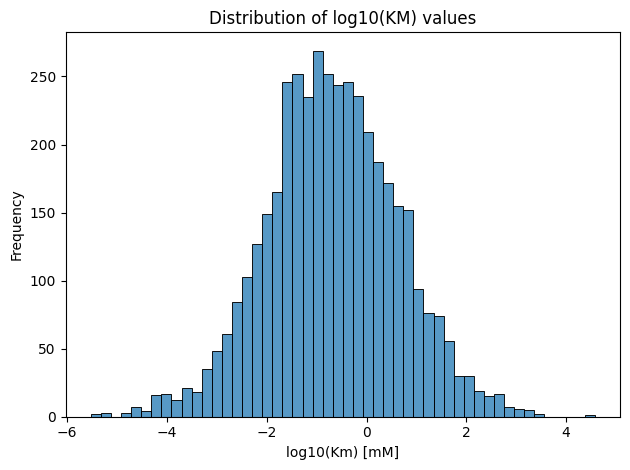

In [38]:
# Plot the distribution
fig, ax = plt.subplots()
sns.histplot(km_df["log_km"], bins=50)

ax.set_title("Distribution of log10(KM) values")
ax.set_xlabel("log10(Km) [mM]")
ax.set_ylabel("Frequency")

#plt.grid(True)
plt.tight_layout()
plt.show()

Download amino acid sequences for all data points

In [ ]:
# Save all unique Uniprot IDs
IDs = list(set(km_df["uniprot"]))

with open("esm2/UNIPROT_IDs_sabio_v2.txt", "w") as file:
    for ID in IDs:
        file.write(str(ID) + "\n")

Map Uniprot IDs to amino acid sequence

In [39]:
# Map from https://www.uniprot.org/id-mapping uniprot IDs to amino acid sequences
sequence_df = pd.read_csv(("esm2/idmapping_sabio_final_v2.tsv"), sep = "\t")

sequence_df.drop(columns = ["From"], inplace = True)
sequence_df.rename(columns={"Entry": "uniprot"}, inplace=True)

sequence_df["Sequence ID"] = "sequence_" + (sequence_df.index).astype(str)
sequence_df

,uniprot,Sequence,Sequence ID
0,Q0GYU4,MASKTYTLNTGAKIPAVGFGTFANEGAKGETYAAVTKALDVGYRHL...,sequence_0
1,Q04828,MDSKYQCVKLNDGHFMPVLGFGTYAPAEVPKSKALEATKLAIEAGF...,sequence_1
2,P0C2T6,MKITSRKVVVIGTGFVGTSIAYSMINQGLVNELVLIDVNQDKAEGE...,sequence_2
3,P04034,MADKQRKKVILVGDGAVGSSYAFALVNQGIAQELGIVDLFKEKTQG...,sequence_3
4,P17183,MSIEKIWAREILDSRGNPTVEVDLYTAKGLFRAAVPSGASTGIYEA...,sequence_4
...,...,...,...
665,P05091,MLRAAARFGPRLGRRLLSAAATQAVPAPNQQPEVFCNQIFINNEWH...,sequence_665
666,Q9K578,MKKVLSLTALMMVLNHSSFAYPMPNPFPPFRIAGNLYYVGTDDLAS...,sequence_666
667,P16622,MLSRTIRTQGSFLRRSQLTITRSFSVTFNMQNAQKRSPTGIVLMNM...,sequence_667
668,Q49095,MMQRRHFLQKTLLALPIIFSGNLLTGCKTNLSDDYLPDDKITNNPN...,sequence_668


In [40]:
sequence_df = sequence_df.drop_duplicates(subset=["uniprot"])
sequence_df

,uniprot,Sequence,Sequence ID
0,Q0GYU4,MASKTYTLNTGAKIPAVGFGTFANEGAKGETYAAVTKALDVGYRHL...,sequence_0
1,Q04828,MDSKYQCVKLNDGHFMPVLGFGTYAPAEVPKSKALEATKLAIEAGF...,sequence_1
2,P0C2T6,MKITSRKVVVIGTGFVGTSIAYSMINQGLVNELVLIDVNQDKAEGE...,sequence_2
3,P04034,MADKQRKKVILVGDGAVGSSYAFALVNQGIAQELGIVDLFKEKTQG...,sequence_3
4,P17183,MSIEKIWAREILDSRGNPTVEVDLYTAKGLFRAAVPSGASTGIYEA...,sequence_4
...,...,...,...
665,P05091,MLRAAARFGPRLGRRLLSAAATQAVPAPNQQPEVFCNQIFINNEWH...,sequence_665
666,Q9K578,MKKVLSLTALMMVLNHSSFAYPMPNPFPPFRIAGNLYYVGTDDLAS...,sequence_666
667,P16622,MLSRTIRTQGSFLRRSQLTITRSFSVTFNMQNAQKRSPTGIVLMNM...,sequence_667
668,Q49095,MMQRRHFLQKTLLALPIIFSGNLLTGCKTNLSDDYLPDDKITNNPN...,sequence_668


In [41]:
sequence_df = sequence_df.drop_duplicates(subset=["Sequence"]) 
sequence_df

,uniprot,Sequence,Sequence ID
0,Q0GYU4,MASKTYTLNTGAKIPAVGFGTFANEGAKGETYAAVTKALDVGYRHL...,sequence_0
1,Q04828,MDSKYQCVKLNDGHFMPVLGFGTYAPAEVPKSKALEATKLAIEAGF...,sequence_1
2,P0C2T6,MKITSRKVVVIGTGFVGTSIAYSMINQGLVNELVLIDVNQDKAEGE...,sequence_2
3,P04034,MADKQRKKVILVGDGAVGSSYAFALVNQGIAQELGIVDLFKEKTQG...,sequence_3
4,P17183,MSIEKIWAREILDSRGNPTVEVDLYTAKGLFRAAVPSGASTGIYEA...,sequence_4
...,...,...,...
665,P05091,MLRAAARFGPRLGRRLLSAAATQAVPAPNQQPEVFCNQIFINNEWH...,sequence_665
666,Q9K578,MKKVLSLTALMMVLNHSSFAYPMPNPFPPFRIAGNLYYVGTDDLAS...,sequence_666
667,P16622,MLSRTIRTQGSFLRRSQLTITRSFSVTFNMQNAQKRSPTGIVLMNM...,sequence_667
668,Q49095,MMQRRHFLQKTLLALPIIFSGNLLTGCKTNLSDDYLPDDKITNNPN...,sequence_668


In [42]:
# Delete sequences with less than 40 residues or NaN
sequence_df = sequence_df.dropna(subset=["Sequence"])
sequence_df = sequence_df[sequence_df["Sequence"].str.len() >= 40]

sequence_df

,uniprot,Sequence,Sequence ID
0,Q0GYU4,MASKTYTLNTGAKIPAVGFGTFANEGAKGETYAAVTKALDVGYRHL...,sequence_0
1,Q04828,MDSKYQCVKLNDGHFMPVLGFGTYAPAEVPKSKALEATKLAIEAGF...,sequence_1
2,P0C2T6,MKITSRKVVVIGTGFVGTSIAYSMINQGLVNELVLIDVNQDKAEGE...,sequence_2
3,P04034,MADKQRKKVILVGDGAVGSSYAFALVNQGIAQELGIVDLFKEKTQG...,sequence_3
4,P17183,MSIEKIWAREILDSRGNPTVEVDLYTAKGLFRAAVPSGASTGIYEA...,sequence_4
...,...,...,...
665,P05091,MLRAAARFGPRLGRRLLSAAATQAVPAPNQQPEVFCNQIFINNEWH...,sequence_665
666,Q9K578,MKKVLSLTALMMVLNHSSFAYPMPNPFPPFRIAGNLYYVGTDDLAS...,sequence_666
667,P16622,MLSRTIRTQGSFLRRSQLTITRSFSVTFNMQNAQKRSPTGIVLMNM...,sequence_667
668,Q49095,MMQRRHFLQKTLLALPIIFSGNLLTGCKTNLSDDYLPDDKITNNPN...,sequence_668


Merge dataframes to include enzyme sequences

In [43]:
km_df = km_df.merge(sequence_df, how = "left", on = "uniprot")
km_df.rename(columns={"Sequence ID": "sequence_id"}, inplace=True)
km_df

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean,log_km,Sequence,sequence_id
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,[],"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289
1,1.1.99.31,O2,O=O,P20932,wild type,[],[3.2],1,3.20000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[],[0.00089],1,0.00089,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155
3,4.2.1.11,Mg2+,[Mg+2],P25704,wild type,[],[0.054],1,0.05400,-1.267606,MAMQKIFAREILDSRGNPTVEVDLHTAKGRFRAAVPSGASTGIYEA...,sequence_313
4,4.2.1.11,Mn2+,[Mn+2],P25704,wild type,[],[0.0069],1,0.00690,-2.161151,MAMQKIFAREILDSRGNPTVEVDLHTAKGRFRAAVPSGASTGIYEA...,sequence_313
...,...,...,...,...,...,...,...,...,...,...,...,...
4157,1.1.1.21,D-Xylose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110Q,[861.0],1,861.00000,2.935003,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604
4158,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110A,[360.0],1,360.00000,2.556303,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604
4159,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110Q,[1190.0],1,1190.00000,3.075547,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604
4160,1.1.1.21,D-Lyxose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110A,[2740.0],1,2740.00000,3.437751,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604


In [44]:
km_df["mutations"] = km_df["mutations"].apply(lambda x: np.nan if isinstance(x, list) and not x else x)
km_df = km_df.dropna(subset=["Sequence"]).reset_index(drop=True)
km_df

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean,log_km,Sequence,sequence_id
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,NaN,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289
1,1.1.99.31,O2,O=O,P20932,wild type,NaN,[3.2],1,3.20000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,NaN,[0.00089],1,0.00089,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155
3,4.2.1.11,Mg2+,[Mg+2],P25704,wild type,NaN,[0.054],1,0.05400,-1.267606,MAMQKIFAREILDSRGNPTVEVDLHTAKGRFRAAVPSGASTGIYEA...,sequence_313
4,4.2.1.11,Mn2+,[Mn+2],P25704,wild type,NaN,[0.0069],1,0.00690,-2.161151,MAMQKIFAREILDSRGNPTVEVDLHTAKGRFRAAVPSGASTGIYEA...,sequence_313
...,...,...,...,...,...,...,...,...,...,...,...,...
3744,1.1.1.21,D-Xylose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110Q,[861.0],1,861.00000,2.935003,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604
3745,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110A,[360.0],1,360.00000,2.556303,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604
3746,1.1.1.21,L-Xylose,C(C(C(C(C=O)O)O)O)O,P15121,mutant,H110Q,[1190.0],1,1190.00000,3.075547,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604
3747,1.1.1.21,D-Lyxose,C1C(C(C(C(O1)O)O)O)O,P15121,mutant,H110A,[2740.0],1,2740.00000,3.437751,MASRLLLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,sequence_604


In [45]:
km_df = km_df.rename(columns={"Sequence":"sequence"})
tot_mutants = (km_df["enzyme_type"] == "mutant").sum()
print(f"Before applying the mutation we have {tot_mutants} total mutants")

Before applying the mutation we have 1750 total mutants


Apply the mutation in the mutant enzymes

In [46]:
skipped_entries_out_of_range = []
skipped_entries_mismatch = []

def apply_mutations(sequence, mutations, sequence_id):
    if pd.isna(mutations):  
        return sequence # same sequence if the enzyme is a wild type

    mutated_sequence = list(sequence)  
    mutation_list = mutations.split("/")

    for mutation in mutation_list:
        match = re.match(r"([A-Z])(\d+)([A-Z])", mutation)
        if match:
            original_residue, position, new_residue = match.groups()
            position = int(position) - 1  

            if position >= len(mutated_sequence):
                print(f"Mutation position {position + 1} is out of range for Sequence ID: {sequence_id} "
                      f"(Sequence length: {len(mutated_sequence)})")
                skipped_entries_out_of_range.append(sequence_id)  
                return sequence 

            if mutated_sequence[position] == original_residue:
                mutated_sequence[position] = new_residue
            else:
                print(f"Expected {original_residue} at position {position + 1}, "
                      f"found {mutated_sequence[position]} in Sequence ID: {sequence_id}")
                skipped_entries_mismatch.append(sequence_id)  
                return sequence 

    return "".join(mutated_sequence) 

km_df["mutated_sequence"] = km_df.apply(lambda row: apply_mutations(row["sequence"], row["mutations"], row["sequence_id"]), axis=1)

skipped_total_count = len(skipped_entries_out_of_range) + len(skipped_entries_mismatch)
km_df = km_df[~km_df["sequence_id"].isin(set(skipped_entries_out_of_range + skipped_entries_mismatch))].reset_index(drop=True)

Expected G at position 37, found S in Sequence ID: sequence_313
Expected G at position 37, found S in Sequence ID: sequence_313
Expected G at position 37, found S in Sequence ID: sequence_313
Expected G at position 37, found S in Sequence ID: sequence_313
Expected G at position 41, found T in Sequence ID: sequence_313
Expected G at position 41, found T in Sequence ID: sequence_313
Expected G at position 41, found T in Sequence ID: sequence_313
Expected G at position 41, found T in Sequence ID: sequence_313
Expected G at position 41, found T in Sequence ID: sequence_313
Expected G at position 37, found S in Sequence ID: sequence_313
Expected N at position 298, found G in Sequence ID: sequence_647
Expected D at position 252, found I in Sequence ID: sequence_128
Expected D at position 252, found I in Sequence ID: sequence_128
Expected D at position 252, found I in Sequence ID: sequence_128
Expected D at position 252, found I in Sequence ID: sequence_128
Expected D at position 252, found I

In [47]:
print(f"We dropped {len(skipped_entries_out_of_range)} entries because their mutation index was out of range,\n"
      f"and {len(skipped_entries_mismatch)} entries because their registered mutation did not match the sequence residue.\n"
      f"Total discarded entries: {skipped_total_count}")

We dropped 1 entries because their mutation index was out of range,
and 760 entries because their registered mutation did not match the sequence residue.
Total discarded entries: 761


Write fasta files

In [48]:
data = km_df.copy()
set_sequences = data[["sequence_id", "sequence"]].drop_duplicates()

path_to_folder = "./esm2" 

output_file = os.path.join(path_to_folder, "sequences_sabio.fasta")

with open(output_file, "w") as f:
    for i, row in set_sequences.iterrows():
        f.write(f">{row["sequence_id"]}\n")  
        f.write(f"{row["sequence"]}\n")

print(f"FASTA file saved as {output_file}")

FASTA file saved as ./esm2\sequences_sabio.fasta


In [49]:
set_sequences 

,sequence_id,sequence
0,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...
2,sequence_155,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...
3,sequence_378,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...
6,sequence_290,MSERLSITPLGPYIGAQISGADLTRPLSDNQFEQLYHAVLRHQVVF...
9,sequence_467,MSTKYIFVTGGGTSSMGKGIVAASLGRLLKNRGLKVTVQKFDPYLN...
...,...,...
1720,sequence_114,MAILVLGGAGYIGSHMVDRLVEKGQEKVVVVDSLVTGHRAAVHPDA...
1721,sequence_541,MKFREPLLGGSAAMPGASLQRACRLLVAVCALHLGVTLVYYLAGRD...
1722,sequence_18,MEPEAPRRRHTHQRGYLLTRNPHLNKDLAFTLEERQQLNIHGLLPP...
1724,sequence_170,MGAALGTGTRLAPWPGRACGALPRWTPTAPAQGCHSKPGPARPVPL...


In [50]:
data = km_df.copy()
mutants = data[data["enzyme_type"] == "mutant"]
set_mutants = mutants[["mutations", "mutated_sequence"]].drop_duplicates()
set_mutants["mut_sequence_id"] = ["sequence_" + str(i) for i in range(len(set_mutants))]

path_to_folder = "./esm2"  
output_file = os.path.join(path_to_folder, "mutated_sequences_sabio.fasta")

with open(output_file, "w") as f:
    for i, row in set_mutants.iterrows():
        f.write(f">{row["mut_sequence_id"]}\n")  
        f.write(f"{row["mutated_sequence"]}\n")

print(f"FASTA file saved as {output_file}") 

FASTA file saved as ./esm2\mutated_sequences_sabio.fasta


In [51]:
set_mutants

,mutations,mutated_sequence,mut_sequence_id
1737,G81S,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_0
1738,G81V,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_1
1739,G81D,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_2
1740,G81A,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_3
1745,W30A,MISLIAALAVDRVIGMENAMPWNLPADLAAFKRNTLNKPVIMGRHT...,sequence_4
...,...,...,...
2607,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470
2608,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471
2609,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472
2610,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473


### Calculate enzyme representations with ESM2 model

Wild type

In [52]:
# embeddings created on HPC
df_embeddings = pd.read_pickle(join("esm2","esm2_embeddings_sabio.pkl"))

df_embeddings = df_embeddings.reset_index()
df_embeddings["esm2"] = df_embeddings.iloc[:, 1:].values.tolist()
df_embeddings = df_embeddings.rename(columns={"index":"sequence_id"})
df_embeddings

,sequence_id,0,1,2,3,4,5,6,7,8,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,esm2
0,sequence_160,0.004413,-0.082079,0.005051,-0.014336,-0.045847,-0.073903,-0.009530,-0.133978,-0.015262,...,-0.046274,-0.119667,-0.070094,-0.010254,0.022840,0.052438,-0.179979,0.161110,0.089010,"[0.004413185175508261, -0.08207874745130539, 0..."
1,sequence_551,-0.052369,-0.004168,-0.058427,0.105063,-0.008701,-0.080368,0.051609,-0.273678,0.029808,...,-0.023635,-0.028013,-0.016454,-0.058493,-0.097893,0.136524,-0.159210,-0.064467,0.061249,"[-0.05236862599849701, -0.004168299492448568, ..."
2,sequence_81,-0.016430,-0.056510,-0.046318,0.112522,-0.077390,-0.003582,0.089952,-0.008824,-0.063096,...,0.019337,-0.138961,0.076771,-0.027878,-0.069388,0.056362,-0.168177,-0.024927,0.050250,"[-0.016430417075753212, -0.05651043727993965, ..."
3,sequence_609,0.026129,-0.062751,0.057558,0.010624,0.015082,-0.085449,0.078520,-0.162025,-0.072483,...,-0.086712,-0.056995,-0.056109,-0.042947,-0.059170,0.110395,-0.162970,-0.010377,0.053005,"[0.02612931653857231, -0.06275083124637604, 0...."
4,sequence_391,0.042114,0.000624,-0.003355,0.044757,-0.040052,-0.035088,0.045611,0.090092,0.029655,...,0.025667,-0.144336,0.046243,-0.002817,0.041650,0.042822,-0.031461,0.050996,-0.008861,"[0.042113929986953735, 0.0006240230868570507, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,sequence_19,0.107677,-0.033708,-0.040867,-0.002654,-0.009538,0.055956,-0.095236,-0.073304,0.007858,...,0.001881,-0.079349,0.078702,-0.007626,-0.132328,0.180380,-0.163676,-0.012518,0.028338,"[0.10767745971679688, -0.03370845317840576, -0..."
472,sequence_460,-0.039356,-0.042856,-0.045313,0.016414,-0.067751,-0.038079,0.062922,0.048388,-0.003825,...,-0.007151,-0.155759,0.004906,-0.025863,-0.054672,0.081334,-0.084412,0.017678,0.007569,"[-0.039355721324682236, -0.04285592585802078, ..."
473,sequence_305,0.003913,-0.097986,-0.017843,0.047446,-0.176384,0.008525,0.083103,-0.037872,-0.053621,...,-0.048004,-0.132664,0.062827,-0.039380,-0.125015,0.079458,-0.277084,0.016306,0.118732,"[0.0039134277030825615, -0.09798566997051239, ..."
474,sequence_16,0.013230,-0.085909,0.034903,0.045426,-0.008794,-0.060020,-0.025353,-0.007579,0.016070,...,-0.041283,-0.016090,0.043732,-0.051239,-0.010029,0.146039,-0.109539,-0.063891,0.067296,"[0.013229746371507645, -0.08590864390134811, 0..."


In [53]:
wildtype_df = km_df[km_df["enzyme_type"] == "wild type"]
wildtype_df.drop(columns = ["mutations", "mutated_sequence"], inplace=True)
wildtype_df

,ec,substrate,smiles,uniprot,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.105910,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289
1,1.1.99.31,O2,O=O,P20932,wild type,[3.2],1,3.200000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[0.00089],1,0.000890,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155
3,2.6.1.9,L-Phenylalanine,C1=CC=C(C=C1)CC(C(=O)O)N,Q9X0D0,wild type,[38.0],1,38.000000,1.579784,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378
4,2.6.1.9,L-Tyrosine,C1=CC(=CC=C1CC(C(=O)O)N)O,Q9X0D0,wild type,[2.3],1,2.300000,0.361728,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378
...,...,...,...,...,...,...,...,...,...,...,...
1732,1.1.1.40,Mn2+,[Mn+2],Q16798,wild type,[0.0042],1,0.004200,-2.376751,MGAALGTGTRLAPWPGRACGALPRWTPTAPAQGCHSKPGPARPVPL...,sequence_170
1733,1.1.1.40,NADPH,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,P48163,wild type,[0.0031],1,0.003100,-2.508638,MEPEAPRRRHTHQRGYLLTRNPHLNKDLAFTLEERQQLNIHGLLPP...,sequence_18
1734,1.1.1.40,CO2,C(=O)=O,P48163,wild type,[23.0],1,23.000000,1.361728,MEPEAPRRRHTHQRGYLLTRNPHLNKDLAFTLEERQQLNIHGLLPP...,sequence_18
1735,1.1.1.44,6-Phospho-D-gluconate,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,Q7TP11,wild type,"[0.146, 0.057, 0.157, 0.019]",4,0.070586,-1.151280,MDQKTPEANSRASSPCQEFEQFQIIPTVETPYLARAGKNEFLNLVP...,sequence_362


In [ ]:
df_esm2_sequences = df_embeddings[["sequence_id", "esm2"]]
wildtype_df = wildtype_df.merge(df_esm2_sequences, on="sequence_id", how="left")
wildtype_df.to_pickle(join("files","final_sabio_wildtype_df.pkl"))
wildtype_df 

,ec,substrate,smiles,uniprot,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.105910,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -..."
1,1.1.99.31,O2,O=O,P20932,wild type,[3.2],1,3.200000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -..."
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[0.00089],1,0.000890,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155,"[-0.008569457568228245, -0.0904192328453064, 0..."
3,2.6.1.9,L-Phenylalanine,C1=CC=C(C=C1)CC(C(=O)O)N,Q9X0D0,wild type,[38.0],1,38.000000,1.579784,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0..."
4,2.6.1.9,L-Tyrosine,C1=CC(=CC=C1CC(C(=O)O)N)O,Q9X0D0,wild type,[2.3],1,2.300000,0.361728,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1.1.1.40,Mn2+,[Mn+2],Q16798,wild type,[0.0042],1,0.004200,-2.376751,MGAALGTGTRLAPWPGRACGALPRWTPTAPAQGCHSKPGPARPVPL...,sequence_170,"[0.06878645718097687, -0.0514824315905571, -0...."
1733,1.1.1.40,NADPH,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,P48163,wild type,[0.0031],1,0.003100,-2.508638,MEPEAPRRRHTHQRGYLLTRNPHLNKDLAFTLEERQQLNIHGLLPP...,sequence_18,"[0.08767573535442352, -0.05026205629110336, -0..."
1734,1.1.1.40,CO2,C(=O)=O,P48163,wild type,[23.0],1,23.000000,1.361728,MEPEAPRRRHTHQRGYLLTRNPHLNKDLAFTLEERQQLNIHGLLPP...,sequence_18,"[0.08767573535442352, -0.05026205629110336, -0..."
1735,1.1.1.44,6-Phospho-D-gluconate,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,Q7TP11,wild type,"[0.146, 0.057, 0.157, 0.019]",4,0.070586,-1.151280,MDQKTPEANSRASSPCQEFEQFQIIPTVETPYLARAGKNEFLNLVP...,sequence_362,"[0.048735279589891434, -0.0031023749615997076,..."


Mutants

In [55]:
# embeddings created on HPC
df_mut_embeddings = pd.read_pickle(join("esm2","esm2_mutated_embeddings_sabio.pkl") )

df_mut_embeddings = df_mut_embeddings.reset_index()
df_mut_embeddings["esm2_mut"] = df_mut_embeddings.iloc[:, 1:].values.tolist()
df_mut_embeddings = df_mut_embeddings.rename(columns={"index":"mut_sequence_id"})
df_mut_embeddings

,mut_sequence_id,0,1,2,3,4,5,6,7,8,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,esm2_mut
0,sequence_160,0.036871,-0.001912,-0.052511,-0.036408,-0.088195,-0.079259,0.026702,-0.220593,-0.027011,...,-0.072921,-0.005000,-0.037111,-0.053194,0.006681,0.069807,-0.135375,-0.006379,0.067056,"[0.03687126561999321, -0.0019124302780255675, ..."
1,sequence_193,-0.004520,-0.028153,0.006554,0.033813,-0.149239,-0.027866,0.051171,-0.099218,0.009610,...,-0.092780,-0.111663,0.001253,-0.069603,0.093032,0.062471,-0.223242,0.023734,0.142340,"[-0.004520236048847437, -0.028152963146567345,..."
2,sequence_412,0.029229,-0.077945,-0.090265,0.011158,-0.012076,-0.017491,0.073714,-0.094217,-0.001416,...,-0.076466,-0.037302,-0.063172,-0.028950,0.022095,0.095017,-0.181788,-0.054644,0.128351,"[0.029228920117020607, -0.07794483751058578, -..."
3,sequence_29,-0.002995,-0.090615,0.022688,-0.013772,-0.072096,-0.057717,-0.016596,-0.061294,-0.151517,...,-0.018423,-0.061682,-0.098547,-0.041891,-0.099205,0.094541,-0.266536,0.054117,0.005999,"[-0.0029950146563351154, -0.09061508625745773,..."
4,sequence_81,-0.011375,-0.013938,-0.058600,-0.033253,-0.000833,-0.006289,0.082977,-0.217221,-0.012265,...,-0.023530,-0.068891,-0.037264,0.014432,0.018588,0.071681,-0.069959,-0.031336,0.049678,"[-0.011375398375093937, -0.013937828131020069,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,sequence_37,-0.009519,-0.088091,0.025807,-0.007986,-0.072194,-0.059642,-0.016815,-0.058746,-0.149800,...,-0.019198,-0.060843,-0.101922,-0.040272,-0.105572,0.092744,-0.264037,0.043622,-0.003430,"[-0.009518733248114586, -0.08809096366167068, ..."
471,sequence_19,-0.006974,-0.090911,0.028167,-0.007526,-0.071102,-0.059414,-0.017625,-0.058012,-0.149043,...,-0.016632,-0.063693,-0.096810,-0.044686,-0.104603,0.091198,-0.265992,0.045285,-0.002898,"[-0.006974224932491779, -0.09091059118509293, ..."
472,sequence_460,-0.033290,-0.061829,0.077258,0.016814,-0.043392,-0.080097,0.097192,-0.042815,-0.021027,...,-0.071985,-0.080714,-0.029027,-0.044447,0.050441,0.079889,-0.152714,-0.018630,0.079975,"[-0.033290356397628784, -0.06182926893234253, ..."
473,sequence_305,0.069314,-0.082256,0.028574,0.034483,-0.088795,0.012475,0.053901,-0.222359,-0.007736,...,-0.111827,-0.018451,-0.040545,-0.024176,-0.016016,0.074332,-0.161470,0.001768,0.070044,"[0.06931386888027191, -0.08225633949041367, 0...."


In [56]:
set_mutants

,mutations,mutated_sequence,mut_sequence_id
1737,G81S,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_0
1738,G81V,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_1
1739,G81D,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_2
1740,G81A,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_3
1745,W30A,MISLIAALAVDRVIGMENAMPWNLPADLAAFKRNTLNKPVIMGRHT...,sequence_4
...,...,...,...
2607,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470
2608,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471
2609,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472
2610,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473


In [57]:
df_esm2_mut_sequences = df_mut_embeddings[["mut_sequence_id", "esm2_mut"]]
set_mutants_esm2 = pd.merge(set_mutants[["mutated_sequence","mut_sequence_id"]], df_esm2_mut_sequences, on="mut_sequence_id")
set_mutants_esm2

,mutated_sequence,mut_sequence_id,esm2_mut
0,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_0,"[0.036887530237436295, -0.08449576050043106, -..."
1,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_1,"[0.037923362106084824, -0.0834788903594017, -0..."
2,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_2,"[0.03813271224498749, -0.08308158069849014, -0..."
3,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_3,"[0.037578240036964417, -0.08526875078678131, -..."
4,MISLIAALAVDRVIGMENAMPWNLPADLAAFKRNTLNKPVIMGRHT...,sequence_4,"[-0.006982623599469662, -0.08494529128074646, ..."
...,...,...,...
470,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ..."
471,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -..."
472,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -..."
473,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0..."


In [58]:
mutant_df = km_df[km_df["enzyme_type"] == "mutant"]
mutant_df

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean,log_km,sequence,sequence_id,mutated_sequence
1737,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81S,[2.3],1,2.30,0.361728,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...
1738,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81V,[0.17],1,0.17,-0.769551,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...
1739,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81D,[2.0],1,2.00,0.301030,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...
1740,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81A,[0.04],1,0.04,-1.397940,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...
1741,1.1.99.31,O2,O=O,P20932,mutant,G81A,[1.1],1,1.10,0.041393,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120E,[1.55],1,1.55,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...
2620,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120N,[1.9],1,1.90,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...
2621,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120Q,[6.77],1,6.77,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...
2622,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120S,[2.7],1,2.70,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...


In [ ]:
mutant_df = pd.merge(mutant_df, set_mutants_esm2, on="mutated_sequence", how="left")
mutant_df.to_pickle(join("files","final_sabio_mutant_df.pkl"))
mutant_df

,ec,substrate,smiles,uniprot,enzyme_type,mutations,km,km_count,km_gmean,log_km,sequence,sequence_id,mutated_sequence,mut_sequence_id,esm2_mut
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81S,[2.3],1,2.30,0.361728,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_0,"[0.036887530237436295, -0.08449576050043106, -..."
1,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81V,[0.17],1,0.17,-0.769551,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_1,"[0.037923362106084824, -0.0834788903594017, -0..."
2,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81D,[2.0],1,2.00,0.301030,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_2,"[0.03813271224498749, -0.08308158069849014, -0..."
3,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,mutant,G81A,[0.04],1,0.04,-1.397940,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_3,"[0.037578240036964417, -0.08526875078678131, -..."
4,1.1.99.31,O2,O=O,P20932,mutant,G81A,[1.1],1,1.10,0.041393,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_3,"[0.037578240036964417, -0.08526875078678131, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120E,[1.55],1,1.55,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ..."
883,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120N,[1.9],1,1.90,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -..."
884,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120Q,[6.77],1,6.77,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -..."
885,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,D120S,[2.7],1,2.70,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0..."


Concatenate dataframes

In [58]:
wildtype_df = pd.read_pickle(join("files","final_sabio_wildtype_df.pkl"))
mutant_df = pd.read_pickle(join("files","final_sabio_mutant_df.pkl"))

final_km_df = pd.concat([wildtype_df, mutant_df])
final_km_df.reset_index(inplace=True)
final_km_df = final_km_df.drop(columns="index")
final_km_df

,ec,substrate,smiles,uniprot,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN
1,1.1.99.31,O2,O=O,P20932,wild type,[3.2],1,3.20000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[0.00089],1,0.00089,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155,"[-0.008569457568228245, -0.0904192328453064, 0...",NaN,NaN,NaN,NaN
3,2.6.1.9,L-Phenylalanine,C1=CC=C(C=C1)CC(C(=O)O)N,Q9X0D0,wild type,[38.0],1,38.00000,1.579784,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN
4,2.6.1.9,L-Tyrosine,C1=CC(=CC=C1CC(C(=O)O)N)O,Q9X0D0,wild type,[2.3],1,2.30000,0.361728,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.55],1,1.55000,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ..."
2620,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.9],1,1.90000,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -..."
2621,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[6.77],1,6.77000,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -..."
2622,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[2.7],1,2.70000,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0..."


Calculate ChemBERTa2

In [59]:
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
model = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-10M-MTR")

def ChemBERTa2(smiles):
    inputs = tokenizer(smiles, return_tensors="pt")
    outputs = model(**inputs, output_hidden_states=True)["hidden_states"][-1]
    embedding = outputs[0][1:-1].mean(dim=0).detach().numpy()
    return embedding

final_km_df["ChemBERTa2"] = final_km_df["smiles"].apply(ChemBERTa2)
final_km_df

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,ec,substrate,smiles,uniprot,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.35107562, 0.004365248, 0.10468614, -0.2209..."
1,1.1.99.31,O2,O=O,P20932,wild type,[3.2],1,3.20000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.12906013, -0.41385975, 0.044986498, 0.4085..."
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[0.00089],1,0.00089,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155,"[-0.008569457568228245, -0.0904192328453064, 0...",NaN,NaN,NaN,NaN,"[-0.5621006, -0.28187954, -0.09449702, -0.0408..."
3,2.6.1.9,L-Phenylalanine,C1=CC=C(C=C1)CC(C(=O)O)N,Q9X0D0,wild type,[38.0],1,38.00000,1.579784,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.13801768, 0.028406715, 0.25299802, -0.3514..."
4,2.6.1.9,L-Tyrosine,C1=CC(=CC=C1CC(C(=O)O)N)O,Q9X0D0,wild type,[2.3],1,2.30000,0.361728,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.16540723, -0.23232536, 0.12211868, -0.1834..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.55],1,1.55000,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."
2620,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.9],1,1.90000,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."
2621,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[6.77],1,6.77000,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."
2622,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[2.7],1,2.70000,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."


In [60]:
def array_contains_nan(arr):
    return isinstance(arr, np.ndarray) and np.isnan(arr).any()

final_km_df = final_km_df[~final_km_df["ChemBERTa2"].apply(array_contains_nan)].reset_index(drop=True)
final_km_df

,ec,substrate,smiles,uniprot,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.35107562, 0.004365248, 0.10468614, -0.2209..."
1,1.1.99.31,O2,O=O,P20932,wild type,[3.2],1,3.20000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.12906013, -0.41385975, 0.044986498, 0.4085..."
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[0.00089],1,0.00089,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155,"[-0.008569457568228245, -0.0904192328453064, 0...",NaN,NaN,NaN,NaN,"[-0.5621006, -0.28187954, -0.09449702, -0.0408..."
3,2.6.1.9,L-Phenylalanine,C1=CC=C(C=C1)CC(C(=O)O)N,Q9X0D0,wild type,[38.0],1,38.00000,1.579784,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.13801768, 0.028406715, 0.25299802, -0.3514..."
4,2.6.1.9,L-Tyrosine,C1=CC(=CC=C1CC(C(=O)O)N)O,Q9X0D0,wild type,[2.3],1,2.30000,0.361728,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.16540723, -0.23232536, 0.12211868, -0.1834..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.55],1,1.55000,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."
2620,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.9],1,1.90000,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."
2621,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[6.77],1,6.77000,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."
2622,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[2.7],1,2.70000,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0...","[-0.17341562, -0.17350146, -0.27030548, -0.336..."


In [61]:
def combine_esm2_chemberta(row):
    if row["enzyme_type"] == "mutant":
        esm = row.get("esm2_mut")
    else:
        esm = row.get("esm2")
    
    chemberta = row.get("ChemBERTa2")

    if isinstance(esm, (list, np.ndarray)) and isinstance(chemberta, (list, np.ndarray)):
        return list(esm) + list(chemberta)
    else:
        return None

final_km_df["esm2_ChemBERTa2"] = final_km_df.apply(combine_esm2_chemberta, axis=1)
final_km_df

,ec,substrate,smiles,uniprot,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.10591,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.35107562, 0.004365248, 0.10468614, -0.2209...","[0.036715056747198105, -0.08720541000366211, -..."
1,1.1.99.31,O2,O=O,P20932,wild type,[3.2],1,3.20000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.12906013, -0.41385975, 0.044986498, 0.4085...","[0.036715056747198105, -0.08720541000366211, -..."
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[0.00089],1,0.00089,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155,"[-0.008569457568228245, -0.0904192328453064, 0...",NaN,NaN,NaN,NaN,"[-0.5621006, -0.28187954, -0.09449702, -0.0408...","[-0.008569457568228245, -0.0904192328453064, 0..."
3,2.6.1.9,L-Phenylalanine,C1=CC=C(C=C1)CC(C(=O)O)N,Q9X0D0,wild type,[38.0],1,38.00000,1.579784,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.13801768, 0.028406715, 0.25299802, -0.3514...","[0.130533367395401, -0.10188953578472137, -0.0..."
4,2.6.1.9,L-Tyrosine,C1=CC(=CC=C1CC(C(=O)O)N)O,Q9X0D0,wild type,[2.3],1,2.30000,0.361728,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.16540723, -0.23232536, 0.12211868, -0.1834...","[0.130533367395401, -0.10188953578472137, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.55],1,1.55000,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.010162154212594032, -0.039730362594127655, ..."
2620,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[1.9],1,1.90000,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009560341015458107, -0.03898082301020622, -..."
2621,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[6.77],1,6.77000,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009366334415972233, -0.04053125157952309, -..."
2622,3.5.2.6,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,P04190,mutant,[2.7],1,2.70000,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.00943704228848219, -0.03883534297347069, -0..."


In [62]:
final_km_df.to_pickle(join("files","final_km_df_sabio.pkl"))
#final_km_df.to_csv(join("files","final_km_df_sabio.csv"))

In [63]:
tot_mut = (final_km_df["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (final_km_df["enzyme_type"] == "wild type").sum()
print(tot_wt)

887
1737


In [64]:
final_km_df_sabio_wt = final_km_df[final_km_df["enzyme_type"] == "wild type"].copy()
final_km_df_sabio_wt.to_pickle(join("files","final_km_df_sabio_wt.pkl"))

### Concatenate wt and mut of brenda and sabio-rk

In [6]:
full_brenda_df = pd.read_pickle(join("files","final_km_df_brenda.pkl"))
full_sabio_df = pd.read_pickle(join("files","final_km_df_sabio.pkl"))
final_brenda_sabio_df = pd.concat([full_brenda_df, full_sabio_df])
final_brenda_sabio_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.056,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.03968055173754692, -0.008533140644431114, -..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.010,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ...","[0.0005187500501051545, -0.06791067123413086, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.700,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[-0.009646852500736713, -0.012489923276007175,..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.0074097346514463425, -0.0495544858276844, -..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.033,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN,"[-0.086237095, 0.48899588, 0.5615026, -0.64097...","[-0.01422181911766529, -0.032965607941150665, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[1.55],1,1.550,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.010162154212594032, -0.039730362594127655, ..."
2620,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[1.9],1,1.900,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009560341015458107, -0.03898082301020622, -..."
2621,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[6.77],1,6.770,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009366334415972233, -0.04053125157952309, -..."
2622,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[2.7],1,2.700,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.00943704228848219, -0.03883534297347069, -0..."


In [ ]:
#full_brenda_df.to_csv(join("files","final_km_df_brenda.csv"))

Cut tails

In [7]:
final_brenda_sabio_df = final_brenda_sabio_df[(final_brenda_sabio_df["log_km"] >= -6) & (final_brenda_sabio_df["log_km"] <= 4)]
final_brenda_sabio_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.056,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.03968055173754692, -0.008533140644431114, -..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.010,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ...","[0.0005187500501051545, -0.06791067123413086, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.700,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[-0.009646852500736713, -0.012489923276007175,..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.0074097346514463425, -0.0495544858276844, -..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.033,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN,"[-0.086237095, 0.48899588, 0.5615026, -0.64097...","[-0.01422181911766529, -0.032965607941150665, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[1.55],1,1.550,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.010162154212594032, -0.039730362594127655, ..."
2620,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[1.9],1,1.900,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009560341015458107, -0.03898082301020622, -..."
2621,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[6.77],1,6.770,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009366334415972233, -0.04053125157952309, -..."
2622,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[2.7],1,2.700,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.00943704228848219, -0.03883534297347069, -0..."


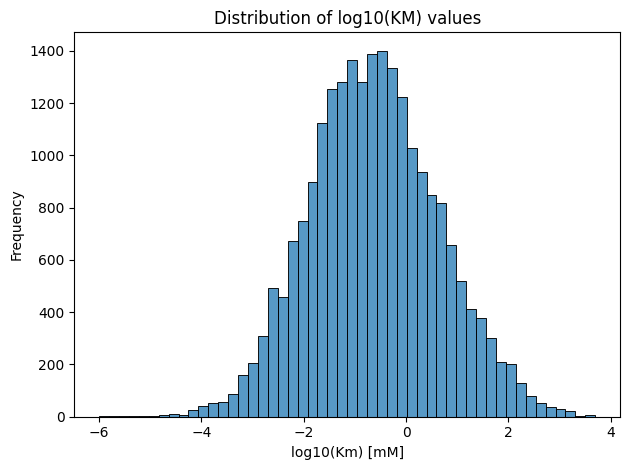

In [67]:
# Plot the distribution
fig, ax = plt.subplots()
sns.histplot(final_brenda_sabio_df["log_km"], bins=50)

ax.set_title("Distribution of log10(KM) values")
ax.set_xlabel("log10(Km) [mM]")
ax.set_ylabel("Frequency")

#.grid(True)
plt.tight_layout()
plt.show()

In [8]:
tot_mut = (final_brenda_sabio_df["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (final_brenda_sabio_df["enzyme_type"] == "wild type").sum()
print(tot_wt)

6249
16318


Drop duplicates

In [9]:
wt_df = final_brenda_sabio_df[final_brenda_sabio_df["enzyme_type"] == "wild type"]
mut_df = final_brenda_sabio_df[final_brenda_sabio_df["enzyme_type"] == "mutant"]

wt_df = wt_df.drop_duplicates(subset=["ec", "substrate", "sequence"], keep="first")
mut_df = mut_df.drop_duplicates(subset=["ec", "substrate", "sequence", "mutations"], keep="first")

final_brenda_sabio_df = pd.concat([wt_df, mut_df]).reset_index(drop=True)

In [70]:
tot_mut = (full_sabio_df["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (full_sabio_df["enzyme_type"] == "wild type").sum()
print(tot_wt)

887
1737


In [71]:
tot_mut = (full_brenda_df["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (full_brenda_df["enzyme_type"] == "wild type").sum()
print(tot_wt)

5362
14582


In [72]:
tot_mut = (final_brenda_sabio_df["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (final_brenda_sabio_df["enzyme_type"] == "wild type").sum()
print(tot_wt)

6249
16318


In [73]:
final_brenda_sabio_df.to_pickle(join("files","final_brenda_sabio_wt_mut_df.pkl"))
final_brenda_sabio_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.056,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.03968055173754692, -0.008533140644431114, -..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.010,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ...","[0.0005187500501051545, -0.06791067123413086, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.700,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[-0.009646852500736713, -0.012489923276007175,..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.0074097346514463425, -0.0495544858276844, -..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.033,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN,"[-0.086237095, 0.48899588, 0.5615026, -0.64097...","[-0.01422181911766529, -0.032965607941150665, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22562,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[1.55],1,1.550,0.190332,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120E,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_470,"[0.010162154212594032, -0.039730362594127655, ...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.010162154212594032, -0.039730362594127655, ..."
22563,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[1.9],1,1.900,0.278754,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120N,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_471,"[0.009560341015458107, -0.03898082301020622, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009560341015458107, -0.03898082301020622, -..."
22564,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[6.77],1,6.770,0.830589,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120Q,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_472,"[0.009366334415972233, -0.04053125157952309, -...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.009366334415972233, -0.04053125157952309, -..."
22565,3.5.2.6,Penicillin G,P04190,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,mutant,[2.7],1,2.700,0.431364,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_372,NaN,D120S,MKKNTLLKVGLCVGLLGTIQFVSTISSVQASQKVEKTVIKNETGTI...,sequence_473,"[0.00943704228848219, -0.03883534297347069, -0...","[-0.17341562, -0.17350146, -0.27030548, -0.336...","[0.00943704228848219, -0.03883534297347069, -0..."


In [ ]:
final_brenda_sabio = pd.read_pickle(join("files","final_brenda_sabio_wt_mut_df.pkl"))
#final_brenda_sabio.to_csv(join("files","final_brenda_sabio_wt_mut_df.csv"))

In [74]:
len(wt_df)

16318

### Split the data into training and test sets

In [10]:
# shuffle the data frame 
df = wt_df.copy() 
df = df.sample(frac = 1, random_state = 44)
df.reset_index(drop= True, inplace = True)

In [11]:
def split_dataframe_enzyme(frac, df):
    df1 = pd.DataFrame(columns = list(df.columns))
    df2 = pd.DataFrame(columns = list(df.columns))
    
    df.reset_index(inplace = True, drop = True)
    
    train_indices = []
    test_indices = []
    ind = 0

    while len(train_indices) + len(test_indices) < len(df):
        if ind not in train_indices and ind not in test_indices:
            if ind % frac != 0:
                n_old = len(train_indices)
                train_indices.append(ind)
                train_indices = list(set(train_indices))

                while n_old != len(train_indices):
                    n_old = len(train_indices)

                    training_rxn= list(set(df["sequence"].loc[train_indices]))

                    train_indices += (list(df.loc[df["sequence"].isin(training_rxn)].index))
                    train_indices = list(set(train_indices))
                
            else:
                n_old = len(test_indices)
                test_indices.append(ind)
                test_indices = list(set(test_indices)) 

                while n_old != len(test_indices):
                    n_old = len(test_indices)

                    testing_rxn= list(set(df["sequence"].loc[test_indices]))

                    test_indices += (list(df.loc[df["sequence"].isin(testing_rxn)].index))
                    test_indices = list(set(test_indices))
                
        ind +=1
    
    
    df1 = df.loc[train_indices]
    df2 = df.loc[test_indices]
    
    return(df1, df2)

In [12]:
train_df, test_df = split_dataframe_enzyme(frac = 5, df = df.copy())
print("Test set size: %s" % len(test_df))
print("Training set size: %s" % len(train_df))
print("Size of test set in percent: %s" % np.round(100*len(test_df)/ (len(test_df) + len(train_df))))

train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

train_df.to_pickle(join("partitions_brenda_sabio", "train_df.pkl"))
test_df.to_pickle(join("partitions_brenda_sabio", "test_df.pkl"))

Test set size: 3172
Training set size: 13146
Size of test set in percent: 19.0


Cross validation

In [13]:
# 5-fold cross validation is performed such that the same enzyme or reaction does not appear in different folds
data_train2 = train_df.copy()
data_train2["index"] = list(data_train2.index)

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=5)
indices_fold1 = list(df_fold["index"])
print(len(data_train2), len(indices_fold1))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=4)
indices_fold2 = list(df_fold["index"])
print(len(data_train2), len(indices_fold2))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=3)
indices_fold3 = list(df_fold["index"])
print(len(data_train2), len(indices_fold3))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=2)
indices_fold4 = list(df_fold["index"])
indices_fold5 = list(data_train2["index"])
print(len(data_train2), len(indices_fold4))


fold_indices = [indices_fold1, indices_fold2, indices_fold3, indices_fold4, indices_fold5]

train_indices = [[] for _ in range(5)]
test_indices = [[] for _ in range(5)]

for i in range(5):
    for j in range(5):
        if i != j:
            train_indices[i] = train_indices[i] + fold_indices[j]
    test_indices[i] = fold_indices[i]

10647 2499
7966 2681
5158 2808
2601 2557


In [14]:
train_file = join("partitions_brenda_sabio", "CV_train_indices.pkl")
test_file = join("partitions_brenda_sabio", "CV_test_indices.pkl")

with open(train_file, "wb") as f:
    pickle.dump(train_indices, f)

with open(test_file, "wb") as f:
    pickle.dump(test_indices, f)

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

train_X = np.vstack(train_df["esm2_ChemBERTa2"].values) 
test_X = np.vstack(test_df["esm2_ChemBERTa2"].values)

train_y = train_df["log_km"].values
test_y = test_df["log_km"].values

model = Ridge(alpha=1)
model.fit(train_X, train_y)

test_pred = model.predict(test_X)
test_mse = mean_squared_error(test_y, test_pred)

test_r2 = r2_score(test_y, test_pred)
print(f"test_mse: {test_mse:.4f}, test_r2: {test_r2:.4f}") #0.37

test_mse: 0.9632, test_r2: 0.3360


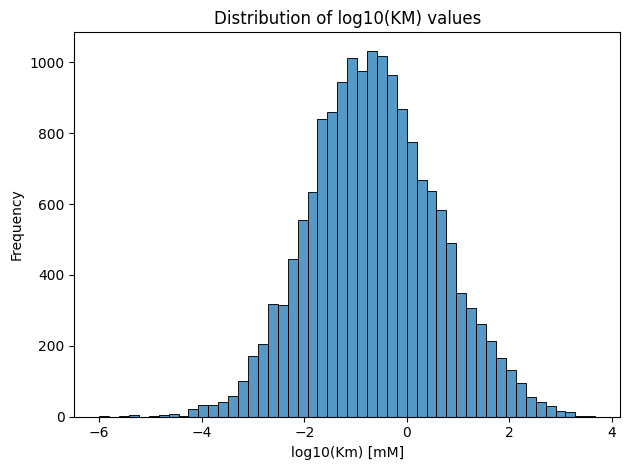

In [80]:
# Plot the distribution
fig, ax = plt.subplots()
sns.histplot(df["log_km"], bins=50)

ax.set_title("Distribution of log10(KM) values")
ax.set_xlabel("log10(Km) [mM]")
ax.set_ylabel("Frequency")

#.grid(True)
plt.tight_layout()
plt.show()

Get the BRENDA only partitions

In [ ]:
full_brenda_df = pd.read_pickle(join("files","final_km_df_brenda.pkl"))
full_brenda_df = full_brenda_df[(full_brenda_df["log_km"] >= -6) & (full_brenda_df["log_km"] <= 4)]
full_brenda_wt_df  = full_brenda_df[full_brenda_df["enzyme_type"] == "wild type"].copy()
full_brenda_wt_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.056000,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.03968055173754692, -0.008533140644431114, -..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.010000,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ...","[0.0005187500501051545, -0.06791067123413086, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.700000,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[-0.009646852500736713, -0.012489923276007175,..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.000000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.0074097346514463425, -0.0495544858276844, -..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.033000,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN,"[-0.086237095, 0.48899588, 0.5615026, -0.64097...","[-0.01422181911766529, -0.032965607941150665, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585,7.6.2.3,atp,Q8QG98,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,"[0.5, 0.4]",2,0.447214,-0.349485,MTDVLDTYCGSTFWNASLLDRPDPDLTVCFEQTVLVWVPLAFLWIC...,sequence_887,"[-0.03302926942706108, -0.06948782503604889, -...",NaN,NaN,NaN,NaN,"[0.7675022, -0.61256504, -0.04781859, 0.743911...","[-0.03302926942706108, -0.06948782503604889, -..."
14586,7.6.2.3,atp,P39109,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[0.0865],1,0.086500,-1.062984,MAGNLVSWACKLCRSPEGFGPISFYGDFTQCFIDGVILNLSAIFMI...,sequence_4451,"[-0.0037712478078901768, -0.029883839190006256...",NaN,NaN,NaN,NaN,"[0.7675022, -0.61256504, -0.04781859, 0.743911...","[-0.0037712478078901768, -0.029883839190006256..."
14587,7.6.2.9,betaine,Q0PCR9,C[N+](C)(C)CC(=O)[O-],wild type,"[0.128, 0.143, 0.272, 0.0608, 0.0834, 0.0919, ...",8,0.060590,-1.217598,MVKQSKRPDFEEELLEEQPERYPGDTNFQKWGFDLHPQVAPISGGL...,sequence_4564,"[0.010143803432583809, -0.0484558641910553, -0...",NaN,NaN,NaN,NaN,"[-0.044458658, -0.50271213, -0.06864436, 0.128...","[0.010143803432583809, -0.0484558641910553, -0..."
14588,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[0.6],1,0.600000,-0.221849,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,"[-0.01499115489423275, 0.013553076423704624, -...",NaN,NaN,NaN,NaN,"[0.7675022, -0.61256504, -0.04781859, 0.743911...","[-0.01499115489423275, 0.013553076423704624, -..."


In [19]:
# shuffle the data frame 
df = full_brenda_wt_df.copy() 
df = df.sample(frac = 1, random_state = 44)
df.reset_index(drop= True, inplace = True)

In [20]:
def split_dataframe_enzyme(frac, df):
    df1 = pd.DataFrame(columns = list(df.columns))
    df2 = pd.DataFrame(columns = list(df.columns))
    
    df.reset_index(inplace = True, drop = True)
    
    train_indices = []
    test_indices = []
    ind = 0

    while len(train_indices) + len(test_indices) < len(df):
        if ind not in train_indices and ind not in test_indices:
            if ind % frac != 0:
                n_old = len(train_indices)
                train_indices.append(ind)
                train_indices = list(set(train_indices))

                while n_old != len(train_indices):
                    n_old = len(train_indices)

                    training_rxn= list(set(df["sequence"].loc[train_indices]))

                    train_indices += (list(df.loc[df["sequence"].isin(training_rxn)].index))
                    train_indices = list(set(train_indices))
                
            else:
                n_old = len(test_indices)
                test_indices.append(ind)
                test_indices = list(set(test_indices)) 

                while n_old != len(test_indices):
                    n_old = len(test_indices)

                    testing_rxn= list(set(df["sequence"].loc[test_indices]))

                    test_indices += (list(df.loc[df["sequence"].isin(testing_rxn)].index))
                    test_indices = list(set(test_indices))
                
        ind +=1
    
    
    df1 = df.loc[train_indices]
    df2 = df.loc[test_indices]
    
    return(df1, df2)

In [ ]:
train_df, test_df = split_dataframe_enzyme(frac = 5, df = df.copy())
print("Test set size: %s" % len(test_df))
print("Training set size: %s" % len(train_df))
print("Size of test set in percent: %s" % np.round(100*len(test_df)/ (len(test_df) + len(train_df))))

train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

train_df.to_pickle(join("partitions_brenda", "train_df.pkl"))
test_df.to_pickle(join("partitions_brenda", "test_df.pkl"))

Test set size: 2860
Training set size: 11723
Size of test set in percent: 20.0


In [22]:
# 5-fold cross validation is performed such that the same enzyme or reaction does not appear in different folds
data_train2 = train_df.copy()
data_train2["index"] = list(data_train2.index)

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=5)
indices_fold1 = list(df_fold["index"])
print(len(data_train2), len(indices_fold1))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=4)
indices_fold2 = list(df_fold["index"])
print(len(data_train2), len(indices_fold2))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=3)
indices_fold3 = list(df_fold["index"])
print(len(data_train2), len(indices_fold3))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=2)
indices_fold4 = list(df_fold["index"])
indices_fold5 = list(data_train2["index"])
print(len(data_train2), len(indices_fold4))


fold_indices = [indices_fold1, indices_fold2, indices_fold3, indices_fold4, indices_fold5]

train_indices = [[] for _ in range(5)]
test_indices = [[] for _ in range(5)]

for i in range(5):
    for j in range(5):
        if i != j:
            train_indices[i] = train_indices[i] + fold_indices[j]
    test_indices[i] = fold_indices[i]

9463 2260
7054 2409
4777 2277
2386 2391


In [ ]:
train_file = join("partitions_brenda", "CV_train_indices.pkl")
test_file = join("partitions_brenda", "CV_test_indices.pkl")

with open(train_file, "wb") as f:
    pickle.dump(train_indices, f)

with open(test_file, "wb") as f:
    pickle.dump(test_indices, f)

In [24]:
df.head()

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.4.3.3,d-alanine,A0A499UB99,CC(C(=O)O)N,wild type,[2.7],1,2.70000,0.431364,MATNNIVVLGAGVSGLTTAWLLSKDPSNKITVAAKHMPGDYDIEYC...,sequence_5,"[-0.032968670129776, -0.032165929675102234, -0...",NaN,NaN,NaN,NaN,"[-0.19041814, -0.6904807, -0.11429796, -0.0391...","[-0.032968670129776, -0.032165929675102234, -0..."
1,2.7.1.1,d-glucose,A0A220NLA7,C(C1C(C(C(C(O1)O)O)O)O)O,wild type,[0.045],1,0.04500,-1.346787,MSDEQITKKVREICEELILSQENLKEVCDVLHEELNKGLGKDTNPE...,sequence_1240,"[0.036954645067453384, -0.061299167573451996, ...",NaN,NaN,NaN,NaN,"[-0.29570022, -0.4185772, -0.0855532, 0.502187...","[0.036954645067453384, -0.061299167573451996, ..."
2,1.1.1.95,3-phospho-d-glycerate,O49485,C(C(C(=O)O)O)OP(=O)(O)O,wild type,"[0.5, 2.11, 1.308]",3,1.11332,0.046620,MSATAAASSSIAVATNSLRNVTLSSRSPLPSAISVAFPSRGRNTLQ...,sequence_1583,"[0.02633734606206417, -0.0398862287402153, -0....",NaN,NaN,NaN,NaN,"[0.09525315, -0.6578246, 0.33279294, 0.1089921...","[0.02633734606206417, -0.0398862287402153, -0...."
3,2.6.1.2,l-glutamate,F4I7I0,C(CC(=O)O)C(C(=O)O)N,wild type,[2.5],1,2.50000,0.397940,MRRFVIGQAKNLIDQSRRRQLHHHKNLSFVSLIPPFSAPSDSSSRH...,sequence_873,"[0.029941728338599205, -0.024187449365854263, ...",NaN,NaN,NaN,NaN,"[-0.2889754, -0.5852623, 0.08280419, -0.248427...","[0.029941728338599205, -0.024187449365854263, ..."
4,1.1.1.1,nadh,A3MVR8,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.072],1,0.07200,-1.142668,MRAAVIKEWGTPLEVTDVPKPEPGPGEVLVRISASGVCHTDIHQWK...,sequence_2468,"[0.0484975129365921, -0.09456920623779297, -0....",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ...","[0.0484975129365921, -0.09456920623779297, -0...."


Get the SABIORK only partitions

In [ ]:
full_sabio_df = pd.read_pickle(join("files","final_km_df_sabio.pkl"))
full_sabio_df = full_sabio_df[(full_sabio_df["log_km"] >= -6) & (full_sabio_df["log_km"] <= 4)]
full_sabio_wt_df = full_sabio_df[full_sabio_df["enzyme_type"] == "wild type"].copy()
full_sabio_wt_df

,ec,substrate,smiles,uniprot,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.1.99.31,(S)-Mandelate,C1=CC=C(C=C1)C(C(=O)[O-])O,P20932,wild type,"[0.09000000000000001, 0.11, 0.12000000000000001]",3,0.105910,-0.975061,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.35107562, 0.004365248, 0.10468614, -0.2209...","[0.036715056747198105, -0.08720541000366211, -..."
1,1.1.99.31,O2,O=O,P20932,wild type,[3.2],1,3.200000,0.505150,MSQNLFNVEDYRKLRQKRLPKMVYDYLEGGAEDEYGVKHNRDVFQQ...,sequence_289,"[0.036715056747198105, -0.08720541000366211, -...",NaN,NaN,NaN,NaN,"[-0.12906013, -0.41385975, 0.044986498, 0.4085...","[0.036715056747198105, -0.08720541000366211, -..."
2,1.5.1.3,Dihydrofolate,C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)...,P0ABQ4,wild type,[0.00089],1,0.000890,-3.050610,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,sequence_155,"[-0.008569457568228245, -0.0904192328453064, 0...",NaN,NaN,NaN,NaN,"[-0.5621006, -0.28187954, -0.09449702, -0.0408...","[-0.008569457568228245, -0.0904192328453064, 0..."
3,2.6.1.9,L-Phenylalanine,C1=CC=C(C=C1)CC(C(=O)O)N,Q9X0D0,wild type,[38.0],1,38.000000,1.579784,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.13801768, 0.028406715, 0.25299802, -0.3514...","[0.130533367395401, -0.10188953578472137, -0.0..."
4,2.6.1.9,L-Tyrosine,C1=CC(=CC=C1CC(C(=O)O)N)O,Q9X0D0,wild type,[2.3],1,2.300000,0.361728,MNPLDLIAKRAYPYETEKRDKTYLALNENPFPFPEDLVDEVFRRLN...,sequence_378,"[0.130533367395401, -0.10188953578472137, -0.0...",NaN,NaN,NaN,NaN,"[-0.16540723, -0.23232536, 0.12211868, -0.1834...","[0.130533367395401, -0.10188953578472137, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1.1.1.40,Mn2+,[Mn+2],Q16798,wild type,[0.0042],1,0.004200,-2.376751,MGAALGTGTRLAPWPGRACGALPRWTPTAPAQGCHSKPGPARPVPL...,sequence_170,"[0.06878645718097687, -0.0514824315905571, -0....",NaN,NaN,NaN,NaN,"[-0.17374468, -0.50755274, -0.16397545, 0.1843...","[0.06878645718097687, -0.0514824315905571, -0...."
1733,1.1.1.40,NADPH,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,P48163,wild type,[0.0031],1,0.003100,-2.508638,MEPEAPRRRHTHQRGYLLTRNPHLNKDLAFTLEERQQLNIHGLLPP...,sequence_18,"[0.08767573535442352, -0.05026205629110336, -0...",NaN,NaN,NaN,NaN,"[0.8569791, -0.54408675, 0.16633421, 0.5052038...","[0.08767573535442352, -0.05026205629110336, -0..."
1734,1.1.1.40,CO2,C(=O)=O,P48163,wild type,[23.0],1,23.000000,1.361728,MEPEAPRRRHTHQRGYLLTRNPHLNKDLAFTLEERQQLNIHGLLPP...,sequence_18,"[0.08767573535442352, -0.05026205629110336, -0...",NaN,NaN,NaN,NaN,"[0.068291165, -0.60708535, 0.22307621, 0.28961...","[0.08767573535442352, -0.05026205629110336, -0..."
1735,1.1.1.44,6-Phospho-D-gluconate,C(C(C(C(C(C(=O)O)O)O)O)O)OP(=O)(O)O,Q7TP11,wild type,"[0.146, 0.057, 0.157, 0.019]",4,0.070586,-1.151280,MDQKTPEANSRASSPCQEFEQFQIIPTVETPYLARAGKNEFLNLVP...,sequence_362,"[0.048735279589891434, -0.0031023749615997076,...",NaN,NaN,NaN,NaN,"[-0.3554603, -0.56965506, 0.28285924, 0.004907...","[0.048735279589891434, -0.0031023749615997076,..."


In [26]:
# shuffle the data frame 
df = full_sabio_wt_df.copy() 
df = df.sample(frac = 1, random_state = 44)
df.reset_index(drop= True, inplace = True)

In [27]:
def split_dataframe_enzyme(frac, df):
    df1 = pd.DataFrame(columns = list(df.columns))
    df2 = pd.DataFrame(columns = list(df.columns))
    
    df.reset_index(inplace = True, drop = True)
    
    train_indices = []
    test_indices = []
    ind = 0

    while len(train_indices) + len(test_indices) < len(df):
        if ind not in train_indices and ind not in test_indices:
            if ind % frac != 0:
                n_old = len(train_indices)
                train_indices.append(ind)
                train_indices = list(set(train_indices))

                while n_old != len(train_indices):
                    n_old = len(train_indices)

                    training_rxn= list(set(df["sequence"].loc[train_indices]))

                    train_indices += (list(df.loc[df["sequence"].isin(training_rxn)].index))
                    train_indices = list(set(train_indices))
                
            else:
                n_old = len(test_indices)
                test_indices.append(ind)
                test_indices = list(set(test_indices)) 

                while n_old != len(test_indices):
                    n_old = len(test_indices)

                    testing_rxn= list(set(df["sequence"].loc[test_indices]))

                    test_indices += (list(df.loc[df["sequence"].isin(testing_rxn)].index))
                    test_indices = list(set(test_indices))
                
        ind +=1
    
    
    df1 = df.loc[train_indices]
    df2 = df.loc[test_indices]
    
    return(df1, df2)

In [ ]:
train_df, test_df = split_dataframe_enzyme(frac = 5, df = df.copy())
print("Test set size: %s" % len(test_df))
print("Training set size: %s" % len(train_df))
print("Size of test set in percent: %s" % np.round(100*len(test_df)/ (len(test_df) + len(train_df))))

train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

train_df.to_pickle(join("partitions_sabio", "train_df.pkl"))
test_df.to_pickle(join("partitions_sabio", "test_df.pkl"))

Test set size: 299
Training set size: 1437
Size of test set in percent: 17.0


In [29]:
# 5-fold cross validation is performed such that the same enzyme or reaction does not appear in different folds
data_train2 = train_df.copy()
data_train2["index"] = list(data_train2.index)

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=5)
indices_fold1 = list(df_fold["index"])
print(len(data_train2), len(indices_fold1))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=4)
indices_fold2 = list(df_fold["index"])
print(len(data_train2), len(indices_fold2))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=3)
indices_fold3 = list(df_fold["index"])
print(len(data_train2), len(indices_fold3))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=2)
indices_fold4 = list(df_fold["index"])
indices_fold5 = list(data_train2["index"])
print(len(data_train2), len(indices_fold4))


fold_indices = [indices_fold1, indices_fold2, indices_fold3, indices_fold4, indices_fold5]

train_indices = [[] for _ in range(5)]
test_indices = [[] for _ in range(5)]

for i in range(5):
    for j in range(5):
        if i != j:
            train_indices[i] = train_indices[i] + fold_indices[j]
    test_indices[i] = fold_indices[i]

1149 288
853 296
599 254
330 269


In [ ]:
train_file = join("partitions_sabio", "CV_train_indices.pkl")
test_file = join("partitions_sabio", "CV_test_indices.pkl")

with open(train_file, "wb") as f:
    pickle.dump(train_indices, f)

with open(test_file, "wb") as f:
    pickle.dump(test_indices, f)